### Initialization cell: run once on notebook start up

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time as tm, os
import uproot
from scipy.signal import find_peaks
from scipy.fft import fft
%matplotlib widget
myfigwidth = 12
plt.rcParams["figure.figsize"] = (myfigwidth,myfigwidth/2)

def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = tm.perf_counter_ns()
    return

def toc():
    if 'startTime_for_tictoc' in globals():
        global most_recent_toc
        if most_recent_toc > startTime_for_tictoc: print("Toc Warning: Tic not reset.",end="  ")
        most_recent_toc = tm.perf_counter_ns()
        print (f"Elapsed time is {(most_recent_toc - startTime_for_tictoc)*1e-9:.3f} seconds.")
    else:
        print ("Toc Error: start time not set")
    return

def tocms():
    if 'startTime_for_tictoc' in globals():
        global most_recent_toc
        if most_recent_toc > startTime_for_tictoc: print("Toc Warning: Tic not reset.",end="  ")
        most_recent_toc = tm.perf_counter_ns()
        print (f"Elapsed time is {(most_recent_toc - startTime_for_tictoc)*1e-6:.3f} milliseconds.")
    else:
        print ("Toc Error: start time not set")
    return
global most_recent_toc
most_recent_toc = -666

# takes dataarray, 2 collumns of x and y points !!!assumes evenly spaced x points!!! 
#   averages every (2*downsampling + 1) data into single entry in new array
#   averages every (2*smoothing + 1) new array entries without downsampling
def downsmoother(dataarray,downsampling,smoothing):
    listlength = len(dataarray[1])
    downsmoothing = (downsampling*2 + 1)*(smoothing*2 + 1)
    
    downsmootharray = [dataarray[0][downsampling + (downsampling*2 + 1)*smoothing:listlength-(downsmoothing//2):(downsampling*2 + 1)]*1, 
                dataarray[1][:listlength-(downsmoothing - 1):(downsampling*2 + 1)]/(smoothing*2 + 1)]
    
    for shift in range(1,downsmoothing):
        downsmootharray[1] += dataarray[1][shift : listlength-(downsmoothing-1) + shift : (downsampling*2+1)]/(smoothing*2 + 1)
    return downsmootharray

### FFT & Peak Integration

In [102]:
#### Load file

#inputfile=uproot.open("../../REFLECT/hiletgo/darksignals/output1919.root")
inputfile=uproot.open("../../REFLECT/darkcounts/sipm521/output1921.root")
print(f"MIDAS run #{inputfile.keys()[-1][5:9]} loaded. \n\
Available events: {inputfile.keys()[-1][10:14]}")

# for generic csv formats:
#csvdata = np.loadtxt(str(textfilename + ".txt"),float)
#time = csvdata[:,0]
#signal = csvdata[:,1]

MIDAS run #1921 loaded. 
Available events: 6594


Original length: 25000 
Original integral: 4.099e+07
Original sum: 10247390.0

Downsampled/smoothed length: 4998 
Downsampled/smoothed integral: 2.049e+08
Downsampled/smoothed sum: 10243667.001342773
1495.3334


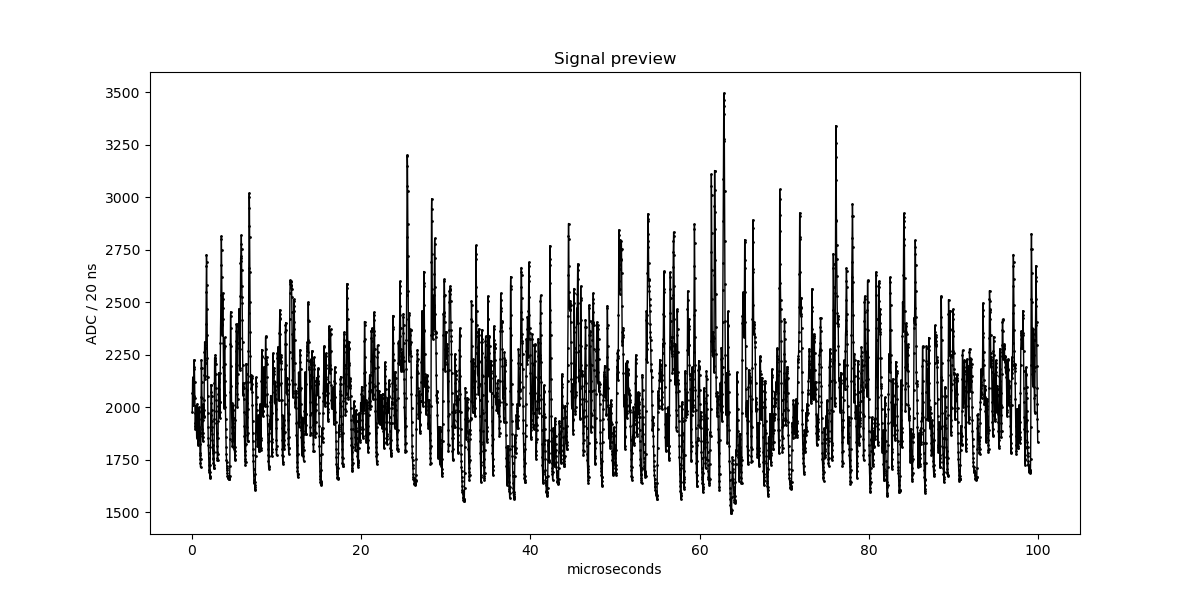

In [104]:
#### Define Inputs
startfreq = 12 #start window at frequency startfreq
hiresrange = 6 # window range

downsampling = 2  # average (2n+1) samples and rebin, retaining center bin time
smoothing = 1     # average (2n+1) samples without rebinning 
NyquistProtection = True
verbose = True

# Select individual sample to tune analysis parameters
samplenum = 20

#### Generate preview
ahist = inputfile[inputfile.keys()[samplenum]].values()
times = inputfile[inputfile.keys()[samplenum]].axis(0).edges()
signal = ahist
time = 0.5*(times[:-1]+times[1:])/1000
if (verbose): print(f"Original length: {len(time)} \nOriginal integral: {sum(signal)*(times[1]-times[0]):.3e}\nOriginal sum: {sum(signal)}")
[time,signal] = downsmoother([time,signal],downsampling,smoothing)
if (verbose): print(f"\nDownsampled/smoothed length: {len(time)} \nDownsampled/smoothed integral: {sum(signal)*(time[1]-time[0])*1000:.3e}\nDownsampled/smoothed sum: {sum(signal)}")

print(min(signal))
plt.close()
plt.plot(time,signal,marker=".",linewidth=1,markersize=2,color="black")
plt.title("Signal preview")
plt.xlabel("microseconds")
plt.ylabel(f"ADC / {(time[1]-time[0])*1000:.0f} ns")
#plt.xlim(0,10)
#plt.ylim(0,1000)
plt.show()

Calculating Fourier amplitudes...
Elapsed time is 1.929 milliseconds.
Window FFT max frequency: 12.31


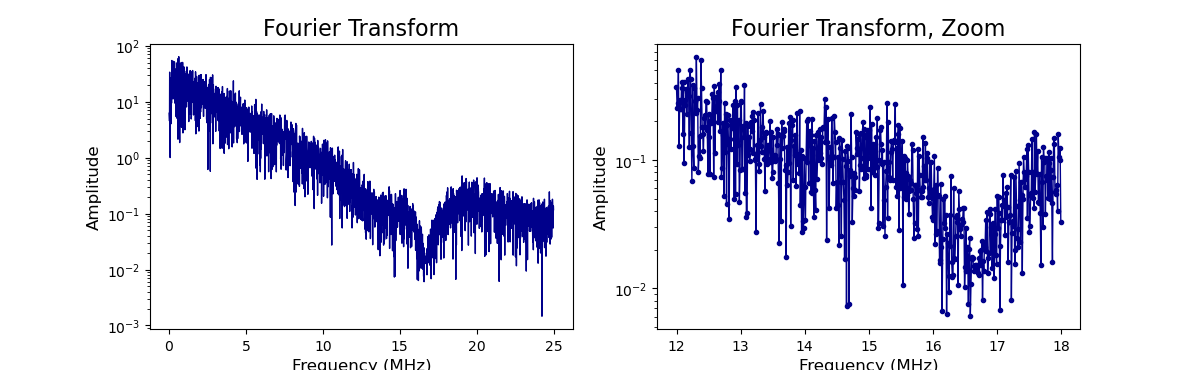

In [92]:
#### Calculate Fourier amplitudes
tic()
print("Calculating Fourier amplitudes...")

if (len(time)%2==0 and NyquistProtection):
    time = time[:-1]
    signal = signal[:-1]

T = time[-1] - time[0] #total integration period
N = len(time) #number of points
fftlength = N//2+1

# The DFT is always symmetric about its midpoint.
# Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
scipyfft = fft(signal)[:fftlength]/(N//2+1/2)

FFTs = np.zeros([3,fftlength]) #Fourier frequencies, amplitudes, and phases
FFTs[0,:] = np.arange(fftlength)/T  #frequencies
FFTs[1,:] = abs(scipyfft)        #amplitudes
FFTs[2,:] = np.arctan2(np.imag(scipyfft),np.real(scipyfft))  #phases

tocms()


if (verbose):
    #  view specific spectral window
    hiresoff = round(startfreq*T)
    hiressamplepoints = round(hiresrange*T) # freq spacing is 1/T
    if (hiresoff>len(FFTs[0])):
        print(f"!! WARNING !! Window beyond Nyquist frequency, {FFTs[0,-1]:.2f} MHz; setting to very high pass")
        hiresoff = len(FFTs[0])-11
        hiressamplepoints = 10
    elif (hiressamplepoints+hiresoff)>len(FFTs[0]): 
        print(f"!! WARNING !! Window cut off at Nyquist frequency, {FFTs[0,-1]:.2f} MHz")
        hiressamplepoints = len(FFTs[0])-1-hiresoff

    FFTshr = np.zeros([3,hiressamplepoints]) #high res window
    FFTshr[0,:] = FFTs[0,hiresoff:hiresoff+hiressamplepoints]
    FFTshr[1,:] = FFTs[1,hiresoff:hiresoff+hiressamplepoints]
    FFTshr[2,:] = FFTs[2,hiresoff:hiresoff+hiressamplepoints]
    print(f"Window FFT max frequency: {FFTshr[0][np.argmax(FFTshr[1])]:.2f}")
    
    # Plot the Fourier spectrum
    plt.close()
    fig,ax = plt.subplots(1,2,figsize=(myfigwidth,myfigwidth/(1+np.sqrt(5))))
    if len(FFTs[0])>100: ax[0].plot(FFTs[0,1:],FFTs[1,1:] ,"-",linewidth=1,color="darkblue") #FFTs[1,:]
    else: ax[0].plot(FFTs[0,:],FFTs[1,:],"-",linewidth=1,marker=".",color="darkblue")

    ax[0].set_title("Fourier Transform", size=16)
    ax[0].set_xlabel("Frequency (MHz)", size=12)
    ax[0].set_ylabel("Amplitude", size=12)
    ax[0].set_yscale('log')
    #ax[0].set_xlim(0.3,0.4)
    #ax[0].set_ylim(0,5)

    ax[1].plot(FFTshr[0],FFTshr[1]*(N/2)/(N//2+1/2),"-",linewidth=1,marker=".",label="Amplitude",color="darkblue")
    ax[1].set_title("Fourier Transform, Zoom", size=16)
    ax[1].set_xlabel("Frequency (MHz)", size=12)
    ax[1].set_ylabel("Amplitude", size=12)
    ax[1].set_yscale('log')
    #ax[1].set_xlim(0.3,0.4)
    #ax[1].set_ylim(0,30)
    '''
    ax[1].legend(loc="upper right")
    axtwin = ax[1].twinx() 
    axtwin.plot(FFTshr[0],np.mod(FFTshr[2]/2/np.pi,1),"-",linewidth=1,marker=".",color="steelblue",label="phase")
    axtwin.legend(loc=(0.76,0.8))
    axtwin.set_ylabel("Phase", size=12)
    '''
    plt.show()

Calculating Inverse FFT...
Elapsed time is 4.303 milliseconds.


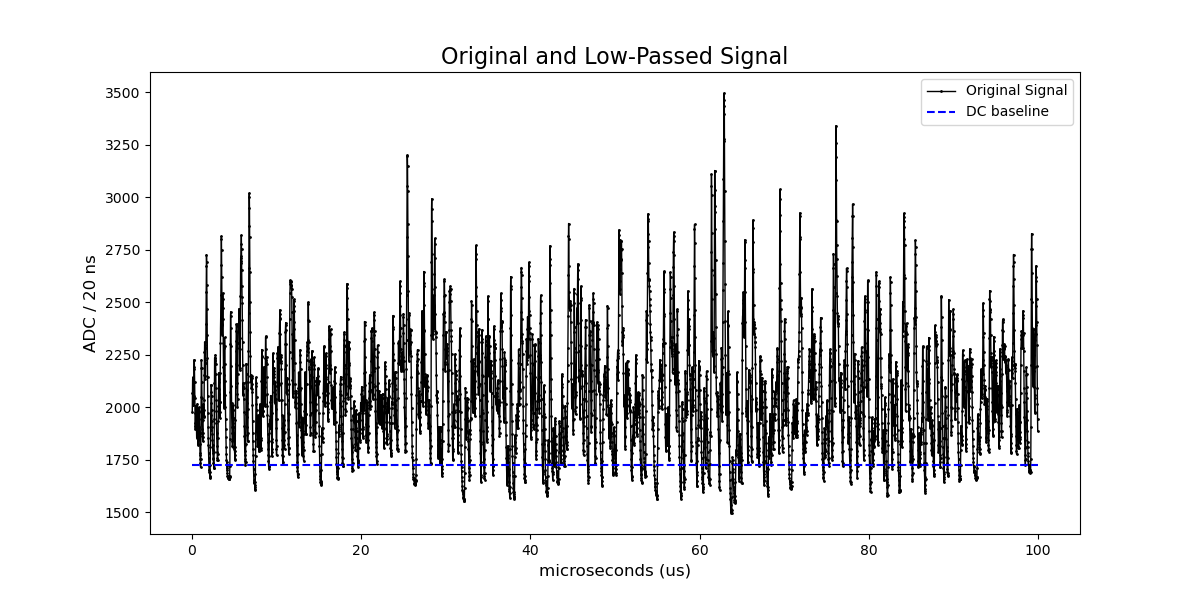

In [93]:
####  Select Lowpass removal
lowpasscut = 1/10
DCoffset = -324 # manual DC offset

#### Remove lowpass from original signal and compare
tic()
print("Calculating Inverse FFT...")

#lowpass
lowpasssamplepoints = round(lowpasscut*T)
if (N*lowpasssamplepoints)>1e8:
    print(f"!!! WARNING !!! Too many lowpass sample points ({N*lowpasssamplepoints:.2e}), risk of crash")
else:
    invexparray = np.exp(2j*np.pi/N* np.outer( np.arange(N),np.arange(lowpasssamplepoints) ))
    arrayfreqs = np.array([FFTs[1,:lowpasssamplepoints] * np.exp(1j*FFTs[2,:lowpasssamplepoints])] * N)

    invFTlp = np.sum(arrayfreqs * invexparray,1)
    ReinvFTlp = np.real(invFTlp) + np.mean(signal) - np.mean(np.real(invFTlp))
tocms()

plt.close()
plt.plot(time,signal,marker=".",linewidth=1,markersize=2,label = "Original Signal",color="black")
plt.plot([time[0],time[-1]],[np.mean(signal)+DCoffset,np.mean(signal)+DCoffset],"--",label="DC baseline",color='blue')
#plt.plot(time,ReinvFTlp+DCoffset,"-",label=f"{lowpasscut:.2f} MHz Lowpass baseline",color='blue')
#plt.plot(time,signal-ReinvFTlp+np.mean(signal),"--",label="FFT recon. window subtract")

plt.legend()
plt.title("Original and Low-Passed Signal", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel(f"ADC / {(time[1]-time[0])*1000:.0f} ns", size=12)
#plt.xlim(0.6,1.1)
plt.show()

In [87]:
np.mean(signal,dtype="float64")+DCoffset

1707.2043884289558

In [88]:
min(signal)

1521.0001

Elapsed time is 2.211 milliseconds.
Number of peaks detected: 265
Average peak height: 601.9


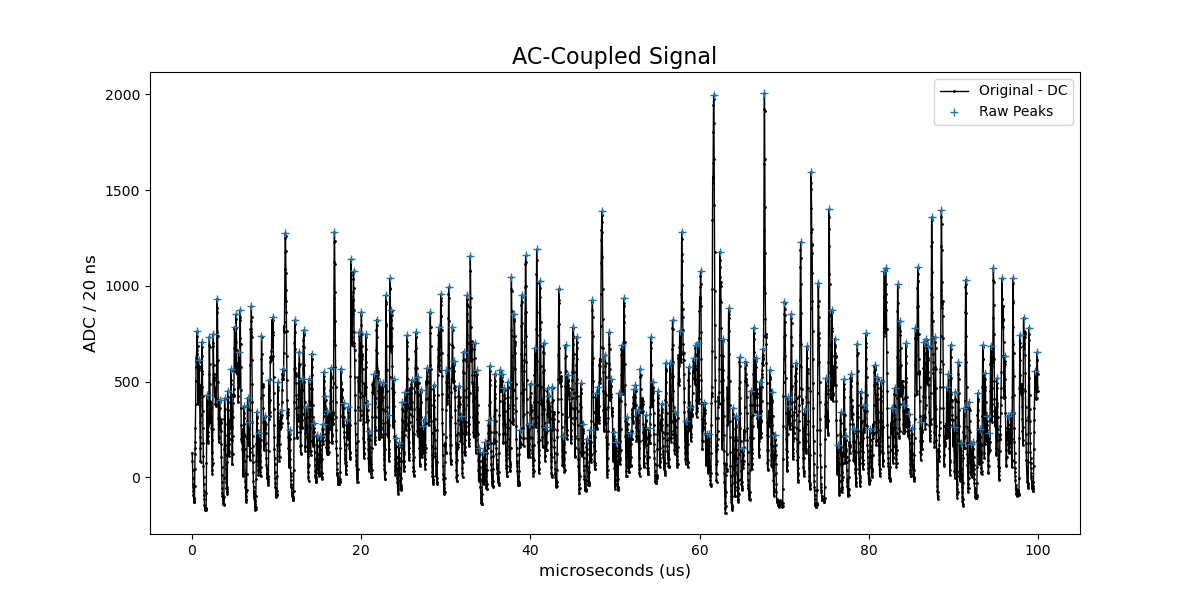

In [86]:
#### Select raw peak-finder parameters
rawpwidth = 3
rawpprom = 10*5
tic()
signal_down = signal-np.mean(signal,dtype="float64")-DCoffset
signal_lp = signal-ReinvFTlp-DCoffset

peaks,props = find_peaks(signal_down,height=0,width=rawpwidth,prominence=rawpprom)
tocms()
plt.close()
plt.plot(time,signal_down,marker=".",linewidth=1,markersize=2,label = "Original - DC",color="black")
#plt.plot(time,signal_down,marker=".",linewidth=1,markersize=2,label=f"Orginal - {lowpasscut:.2f} MHz lowpass")

plt.plot(time[peaks],signal_down[peaks],marker="+",linewidth=0,label="Raw Peaks")
print(f"Number of peaks detected: {len(peaks)}\n\
Average peak height: {np.mean(signal_down[peaks]):.1f}")
plt.legend()
plt.title("AC-Coupled Signal", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel(f"ADC / {(time[1]-time[0])*1000:.0f} ns", size=12)
#plt.xlim(0,48)
plt.show()

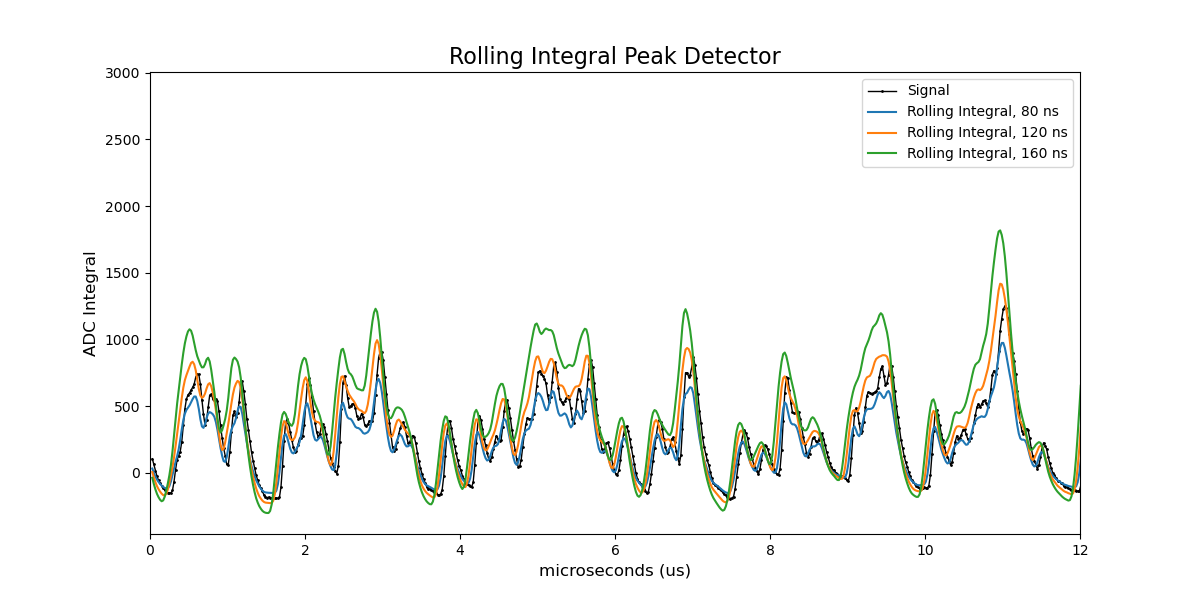

In [319]:
#### Select rolling integral windows to try
mywindows = [4,6,8]

plt.close()
plt.plot(time,signal_down,label="Signal",marker=".",linewidth=1,markersize=2,color="black")

for window in mywindows:
    for shift in range(window):
        if shift == 0: 
            peakfind = 0.2*signal_down[:len(signal_down)+1-window] # divide by 5 for easier comparison to original data
        else: peakfind += 0.2*signal_down[shift:len(signal_down)+1-window+shift]
    plt.plot(time[:1-window],peakfind,label=f"Rolling Integral, {(time[window]-time[0])*1000:.0f} ns")

plt.legend()
plt.title("Rolling Integral Peak Detector", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel("ADC Integral", size=12)
plt.xlim(0,12)
plt.show()
#sum(signal_lp[np.argmin(abs(time-mytime)):np.argmin(abs(time-mytime-mywindow))]),sum(signal_lp[0:-1])

In [7]:
#### Select integral peak-finder parameters
mywindow = 6
pwidth = 2
pprom = 50

for shift in range(mywindow):
    if shift == 0: 
        peakfind = 1/5*signal_down[:len(signal_down)+1-mywindow]
    else: peakfind += 1/5*signal_down[shift:len(signal_down)+1-mywindow+shift]
    
peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom) #

print(f"Number of peaks detected: {len(peaks)}\n\
Average peak height: {np.mean(peakfind[peaks])}")
plt.close()
plt.plot(time,signal_down,label="Signal",marker=".",linewidth=1,markersize=2,color="black")
plt.plot(time[:1-mywindow],peakfind,label=f"Rolling Average, {mywindow} pts")
plt.plot(time[:1-mywindow][peaks],peakfind[peaks],marker="+",linewidth=0)
plt.legend()
plt.title("Integral Peaks", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel("ADC Integral", size=12)
plt.xlim(0,12)
plt.show()

NameError: name 'signal_down' is not defined

## Analyze full run, minima centered

In [ ]:
#### Input selected parameters from above
myset = "hiletgo56"
#inputfile=uproot.open("../../REFLECT/hiletgo/darksignals/output1919.root")
inputfile=uproot.open("../../REFLECT/darkcounts/sipm521/output1921.root")
totsamples = int(inputfile.keys()[-1][10:14])
#totsamples = 1000
lowpasscut = 1/10

if (myset == "raw1"):
    downsampling = 4
    smoothing = 0
    mywindow = [2,3,4]
    rawpwidth = 2
    rawpprom = 3
    pwidth = 2
    pprom = 9
    DCoff = 0
elif (myset == "hiletgo52"):
    downsampling = 3
    smoothing = 0
    mywindow = [6,8,10]
    rawpwidth = 3
    rawpprom = 3
    pwidth = 3
    pprom = 2
    DCoff = -6
elif (myset == "hiletgo55"):
    downsampling = 2
    smoothing = 1
    mywindow = [5,6,7]
    rawpwidth = 2
    rawpprom = 10*5
    pwidth = 2
    pprom = 10*5
    DCoff = -275+58
elif (myset == "hiletgo56"):
    downsampling = 2
    smoothing = 1
    mywindow = [4,5,6]
    rawpwidth = 2
    rawpprom = 50
    pwidth = 2
    pprom = 50
    DCoff = -324
else:
    print("WARNING!!!  Not a valid set!!")

rawpeaks = [-666]*totsamples
intpeaks_s = [-666]*totsamples
intpeaks_m = [-666]*totsamples
intpeaks_l = [-666]*totsamples
rawintegrals = np.array([-666.0]*totsamples)
rawmeans = np.array([-666.0]*totsamples)
signalminima = np.array([-666.0]*totsamples)

pbar = tqdm(total=totsamples,ascii=True,leave=False) 
tic()

times = inputfile[inputfile.keys()[0]].axis(0).edges()

for samplenum in range(totsamples):
    ahist = inputfile[inputfile.keys()[samplenum]].values()
    signal = ahist
    time = 0.5*(times[:-1]+times[1:])/1000
    [time,signal] = downsmoother([time,signal],downsampling,smoothing)
    '''
    T = time[-1] - time[0] #total integration period
    
    N = len(time) #number of points
    
    fftlength = N//2+1
    scipyfft = fft(signal)[:fftlength]/(N//2+1/2)
    FFTs = np.zeros([3,fftlength]) #Fourier frequencies, amplitudes, and phases
    FFTs[0,:] = np.arange(fftlength)/T  #frequencies
    FFTs[1,:] = abs(scipyfft)        #amplitudes
    FFTs[2,:] = np.arctan2(np.imag(scipyfft),np.real(scipyfft))  #phases
    
    lowpasssamplepoints = round(lowpasscut*T)
    invexparray = np.exp(2j*np.pi/N* np.outer( np.arange(N),np.arange(lowpasssamplepoints) ))
    arrayfreqs = np.array([FFTs[1,:lowpasssamplepoints] * np.exp(1j*FFTs[2,:lowpasssamplepoints])] * N)
    invFTlp = np.sum(arrayfreqs * invexparray,1)
    ReinvFTlp = np.real(invFTlp) + np.mean(signal) - np.mean(np.real(invFTlp))
    '''
    signalminima[samplenum] = min(signal)
    signal_lp = signal-DCoff-sum(signal)/len(signal) #-ReinvFTlp   sum(signal)/len(signal)
    rawmeans[samplenum] = sum(signal)/len(signal)
    rawintegrals[samplenum] = sum(signal_lp)
    

    peaks,props = find_peaks(signal_lp,height=0,width=rawpwidth,prominence=rawpprom)
    rawpeaks[samplenum] = signal_lp[peaks]

    for shift in range(mywindow[0]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[0]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[0]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_s[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[1]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[1]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[1]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_m[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[2]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[2]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[2]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_l[samplenum] = peakfind[peaks]

    pbar.update()
pbar.close()
integral_period = 1000/(time[-1]-time[0])
print(f"Analysis Complete!")
toc()

In [118]:
#### Input selected parameters from above
myset = "hiletgo56"
#inputfile=uproot.open("../../REFLECT/hiletgo/darksignals/output1919.root")
inputfile=uproot.open("../../REFLECT/darkcounts/sipm521/output1921.root")
totsamples = int(inputfile.keys()[-1][10:14])
#totsamples = 1000
lowpasscut = 1/10

if (myset == "raw1"):
    downsampling = 4
    smoothing = 0
    mywindow = [2,3,4]
    rawpwidth = 2
    rawpprom = 3
    pwidth = 2
    pprom = 9
    DCoff = 0
elif (myset == "hiletgo52"):
    downsampling = 3
    smoothing = 0
    mywindow = [6,8,10]
    rawpwidth = 3
    rawpprom = 3
    pwidth = 3
    pprom = 2
    DCoff = -6
elif (myset == "hiletgo55"):
    downsampling = 2
    smoothing = 1
    mywindow = [5,6,7]
    rawpwidth = 2
    rawpprom = 10*5
    pwidth = 2
    pprom = 10*5
    DCoff = -275+58
elif (myset == "hiletgo56"):
    downsampling = 2
    smoothing = 1
    mywindow = [4,5,6]
    rawpwidth = 2
    rawpprom = 50
    pwidth = 2
    pprom = 50
    DCoff = -324
    average_min = 1492.2468387232357
else:
    print("WARNING!!!  Not a valid set!!")

rawpeaks = [-666]*totsamples
intpeaks_s = [-666]*totsamples
intpeaks_m = [-666]*totsamples
intpeaks_l = [-666]*totsamples
rawmeans = np.array([-666.0]*totsamples)
signalminima = np.array([-666.0]*totsamples)

pbar = tqdm(total=totsamples,ascii=True,leave=False) 
tic()

times = inputfile[inputfile.keys()[0]].axis(0).edges()

for samplenum in range(totsamples):
    ahist = inputfile[inputfile.keys()[samplenum]].values()
    signal = ahist
    time = 0.5*(times[:-1]+times[1:])/1000
    [time,signal] = downsmoother([time,signal],downsampling,smoothing)

    signalminima[samplenum] = min(signal)
    rawmeans[samplenum] = sum(signal)/len(signal)

    signal_lp = signal-average_min#DCoff-sum(signal)/len(signal) #-ReinvFTlp   sum(signal)/len(signal)

    peaks,props = find_peaks(signal_lp,height=0,width=rawpwidth,prominence=rawpprom)
    rawpeaks[samplenum] = signal_lp[peaks]

    for shift in range(mywindow[0]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[0]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[0]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_s[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[1]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[1]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[1]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_m[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[2]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[2]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[2]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_l[samplenum] = peakfind[peaks]
    
    pbar.update()
pbar.close()
integral_period = 1000/(time[-1]-time[0])
print(f"Analysis Complete!")
toc()


Analysis Complete!
Elapsed time is 56.151 seconds.


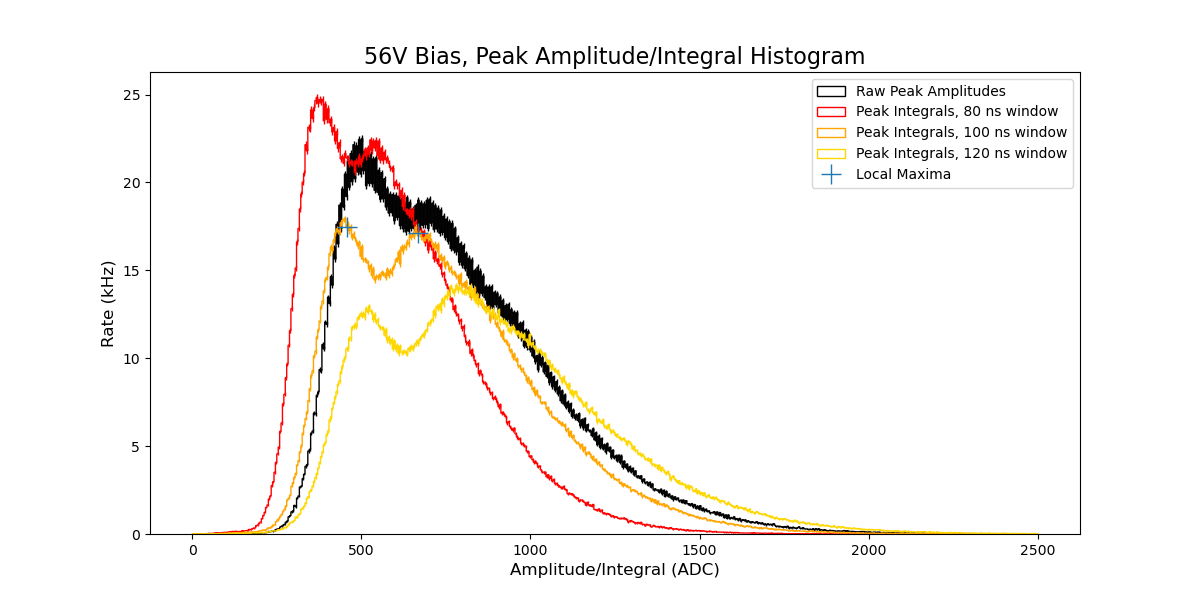

SPE Raw Amplitude: 502.08
Total PE Rate (raw peaks), sum(rate*PE amp): 4975.1 kHz

Integer PE Amplitude (short window): 368.8*5.0
SPE Charge: 1843.75
Total PE Rate, sum(rate*PE amp): 4894.1 kHz

***
1 PE Amplitude (medium window): 456.2*5.0
SPE Charge: 2281.25
Total PE Rate, sum(rate*PE amp): 4590.1 kHz

2 PE Amplitude (medium window): 334.4*5.0
SPE Charge: 1671.88
Total PE Rate, sum(rate*PE amp): 6263.1 kHz

PE Amplitude spacing (medium window): 212.5*5.0
SPE Charge: 1062.50
Total PE Rate, sum(rate*PE amp): 6614.6 kHz
***
Integer PE Amplitude (long window): 390.6*5.0
SPE Charge: 1953.12
Total PE Rate, sum(rate*PE amp): 5941.2 kHz



In [120]:
# was -320, now -330
mybins = 600
myrange = (0,2500)
myreduction = 0.2 # divide integrals by ~5 so distribution can be visually compared to raw peak amplitude distribution

plt.close()
rawpks_s, bins, bars = plt.hist(np.concatenate(rawpeaks),weights=[integral_period/totsamples]*len(np.concatenate(rawpeaks)),bins=mybins,range=myrange,histtype="step",label="Raw Peak Amplitudes",color='black')
amplitude = bins[:-1]*0.5+bins[1:]*0.5
plt.errorbar(amplitude, rawpks_s, yerr=np.sqrt(rawpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='black')

intpks_s, bins, bars = plt.hist(np.concatenate(intpeaks_s)*myreduction,weights=[1000/(time[-mywindow[0]]-time[0])/totsamples]*len(np.concatenate(intpeaks_s)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[0]]-time[0])*1000:.0f} ns window",color='red')
plt.errorbar(amplitude, intpks_s, yerr=np.sqrt(intpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='red')

intpks_m, bins, bars = plt.hist(np.concatenate(intpeaks_m)*myreduction,weights=[1000/(time[-mywindow[1]]-time[0])/totsamples]*len(np.concatenate(intpeaks_m)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[1]]-time[0])*1000:.0f} ns window",color='orange')
plt.errorbar(amplitude, intpks_m, yerr=np.sqrt(intpks_m*10/totsamples),
            linewidth=0, elinewidth=1,color='orange')

intpks_l, bins, bars = plt.hist(np.concatenate(intpeaks_l)*myreduction,weights=[1000/(time[-mywindow[2]]-time[0])/totsamples]*len(np.concatenate(intpeaks_l)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[2]]-time[0])*1000:.0f} ns window",color='gold')
plt.errorbar(amplitude, intpks_l, yerr=np.sqrt(intpks_l*10/totsamples),
            linewidth=0, elinewidth=1,color='gold')

#peaks2,props2 = find_peaks(intpks_s,height=0,width=5,prominence=1,distance=5)
SPEcharge_s = amplitude[np.argmax(intpks_s)]
SPEcharge_m = amplitude[np.argmax(intpks_m)]
SPEcharge_l = amplitude[np.argmax(intpks_l)]/2
peaks2,props2 = find_peaks(intpks_m,height=0,width=5,prominence=2,distance=5)
peaks2[0] += 1
peaks2[1] += 2

SPEcharge_peak1 = amplitude[peaks2[0]]
SPEcharge_peak2 = amplitude[peaks2[1]]/2
SPEcharge_peakdiff = amplitude[peaks2][1]-amplitude[peaks2][0]
amplitude_offset = SPEcharge_peak1-SPEcharge_peakdiff


plt.plot(amplitude[peaks2],intpks_m[peaks2],linestyle="",marker="+",markersize=15,label="Local Maxima")
#plt.yscale("log")
plt.legend()
plt.title("56V Bias, Peak Amplitude/Integral Histogram", size=16)
plt.xlabel("Amplitude/Integral (ADC)", size=12)
plt.ylabel("Rate (kHz)", size=12)
plt.show()

# actual period: time[-mywindow[0]]-time[0]

print(f"SPE Raw Amplitude: {amplitude[np.argmax(rawpks_s)]:.2f}")
print(f"Total PE Rate (raw peaks), sum(rate*PE amp): {sum(rawpks_s*amplitude)/amplitude[np.argmax(rawpks_s)]:.1f} kHz\n")

print(f"Integer PE Amplitude (short window): {SPEcharge_s:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_s/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_s*amplitude)/SPEcharge_s:.1f} kHz\n")

print(f"***\n1 PE Amplitude (medium window): {SPEcharge_peak1:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peak1/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude)/SPEcharge_peak1:.1f} kHz\n")

print(f"2 PE Amplitude (medium window): {SPEcharge_peak2:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peak2/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude)/SPEcharge_peak2:.1f} kHz\n")

print(f"PE Amplitude spacing (medium window): {SPEcharge_peakdiff:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peakdiff/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*(amplitude-amplitude_offset))/SPEcharge_peakdiff:.1f} kHz\n***")


# also want to treat the dark signal the same as the bright signal
    # dcoffset and divide total integral
    # original script only saved averages and stdevs, need to re-analyze

print(f"Integer PE Amplitude (long window): {SPEcharge_l:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_l/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_l*amplitude/SPEcharge_l):.1f} kHz\n")

## Analyze full run

In [110]:
#### Input selected parameters from above
myset = "hiletgo56"
#inputfile=uproot.open("../../REFLECT/hiletgo/darksignals/output1919.root")
inputfile=uproot.open("../../REFLECT/darkcounts/sipm521/output1921.root")
totsamples = int(inputfile.keys()[-1][10:14])
#totsamples = 1000
lowpasscut = 1/10

if (myset == "raw1"):
    downsampling = 4
    smoothing = 0
    mywindow = [2,3,4]
    rawpwidth = 2
    rawpprom = 3
    pwidth = 2
    pprom = 9
    DCoff = 0
elif (myset == "hiletgo52"):
    downsampling = 3
    smoothing = 0
    mywindow = [6,8,10]
    rawpwidth = 3
    rawpprom = 3
    pwidth = 3
    pprom = 2
    DCoff = -6
elif (myset == "hiletgo55"):
    downsampling = 2
    smoothing = 1
    mywindow = [5,6,7]
    rawpwidth = 2
    rawpprom = 10*5
    pwidth = 2
    pprom = 10*5
    DCoff = -275+58
elif (myset == "hiletgo56"):
    downsampling = 2
    smoothing = 1
    mywindow = [4,5,6]
    rawpwidth = 2
    rawpprom = 50
    pwidth = 2
    pprom = 50
    DCoff = -324
else:
    print("WARNING!!!  Not a valid set!!")

rawpeaks = [-666]*totsamples
intpeaks_s = [-666]*totsamples
intpeaks_m = [-666]*totsamples
intpeaks_l = [-666]*totsamples
rawintegrals = np.array([-666.0]*totsamples)
rawmeans = np.array([-666.0]*totsamples)
signalminima = np.array([-666.0]*totsamples)

pbar = tqdm(total=totsamples,ascii=True,leave=False) 
tic()

times = inputfile[inputfile.keys()[0]].axis(0).edges()

for samplenum in range(totsamples):
    ahist = inputfile[inputfile.keys()[samplenum]].values()
    signal = ahist
    time = 0.5*(times[:-1]+times[1:])/1000
    [time,signal] = downsmoother([time,signal],downsampling,smoothing)
    '''
    T = time[-1] - time[0] #total integration period
    
    N = len(time) #number of points
    
    fftlength = N//2+1
    scipyfft = fft(signal)[:fftlength]/(N//2+1/2)
    FFTs = np.zeros([3,fftlength]) #Fourier frequencies, amplitudes, and phases
    FFTs[0,:] = np.arange(fftlength)/T  #frequencies
    FFTs[1,:] = abs(scipyfft)        #amplitudes
    FFTs[2,:] = np.arctan2(np.imag(scipyfft),np.real(scipyfft))  #phases
    
    lowpasssamplepoints = round(lowpasscut*T)
    invexparray = np.exp(2j*np.pi/N* np.outer( np.arange(N),np.arange(lowpasssamplepoints) ))
    arrayfreqs = np.array([FFTs[1,:lowpasssamplepoints] * np.exp(1j*FFTs[2,:lowpasssamplepoints])] * N)
    invFTlp = np.sum(arrayfreqs * invexparray,1)
    ReinvFTlp = np.real(invFTlp) + np.mean(signal) - np.mean(np.real(invFTlp))
    '''
    signalminima[samplenum] = min(signal)
    signal_lp = signal-DCoff-sum(signal)/len(signal) #-ReinvFTlp   sum(signal)/len(signal)
    rawmeans[samplenum] = sum(signal)/len(signal)
    rawintegrals[samplenum] = sum(signal_lp)
    

    peaks,props = find_peaks(signal_lp,height=0,width=rawpwidth,prominence=rawpprom)
    rawpeaks[samplenum] = signal_lp[peaks]

    for shift in range(mywindow[0]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[0]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[0]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_s[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[1]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[1]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[1]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_m[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[2]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[2]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[2]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_l[samplenum] = peakfind[peaks]

    pbar.update()
pbar.close()
integral_period = 1000/(time[-1]-time[0])
print(f"Analysis Complete!")
toc()


Analysis Complete!
Elapsed time is 63.579 seconds.


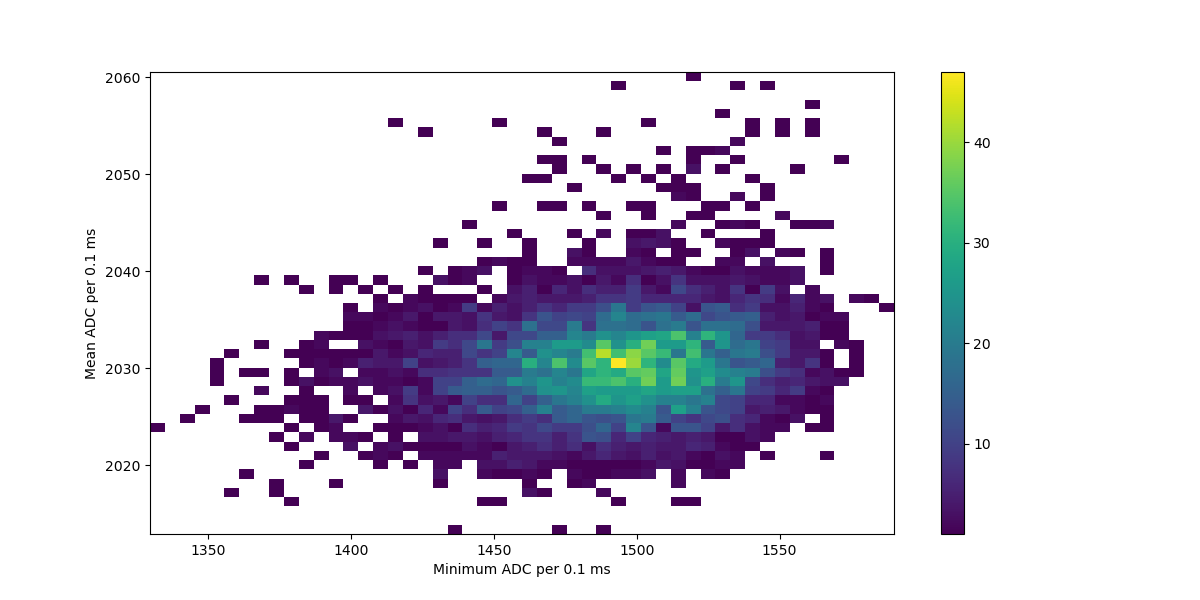

In [123]:
plt.close()
plt.hist2d(signalminima,rawmeans,bins=(50,50),cmin=0.001)
plt.colorbar()
plt.xlabel("Minimum ADC per 0.1 ms")
plt.ylabel("Mean ADC per 0.1 ms")
plt.show()

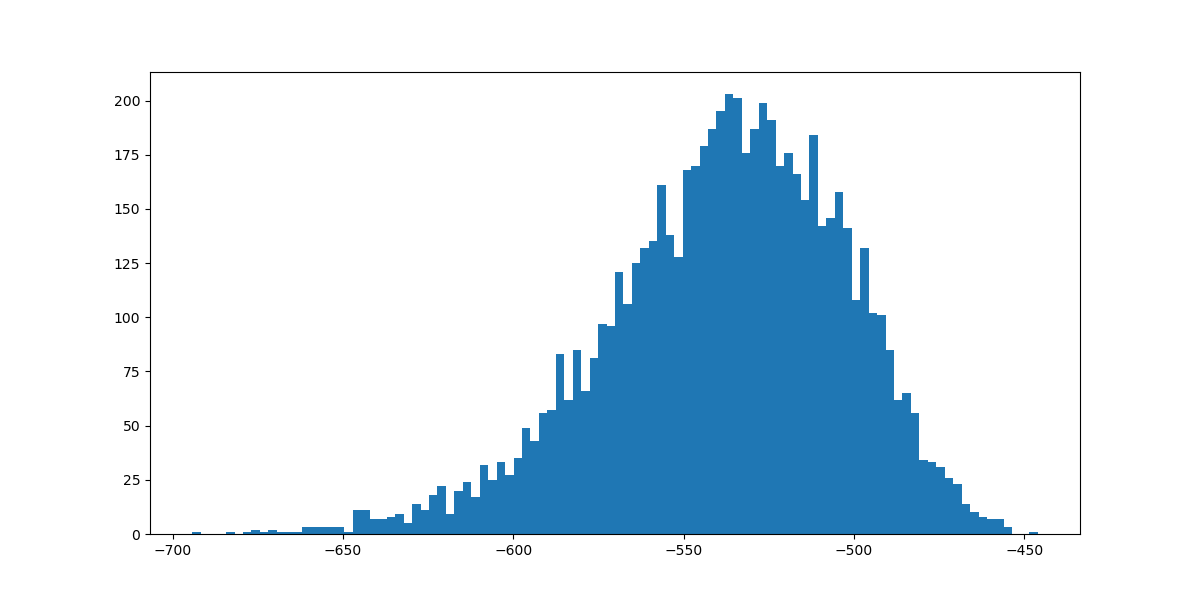

-538.1475047397574

In [129]:
plt.close()
plt.hist(signalminima-rawmeans,bins=(100))
plt.show()
np.mean(signalminima-rawmeans)

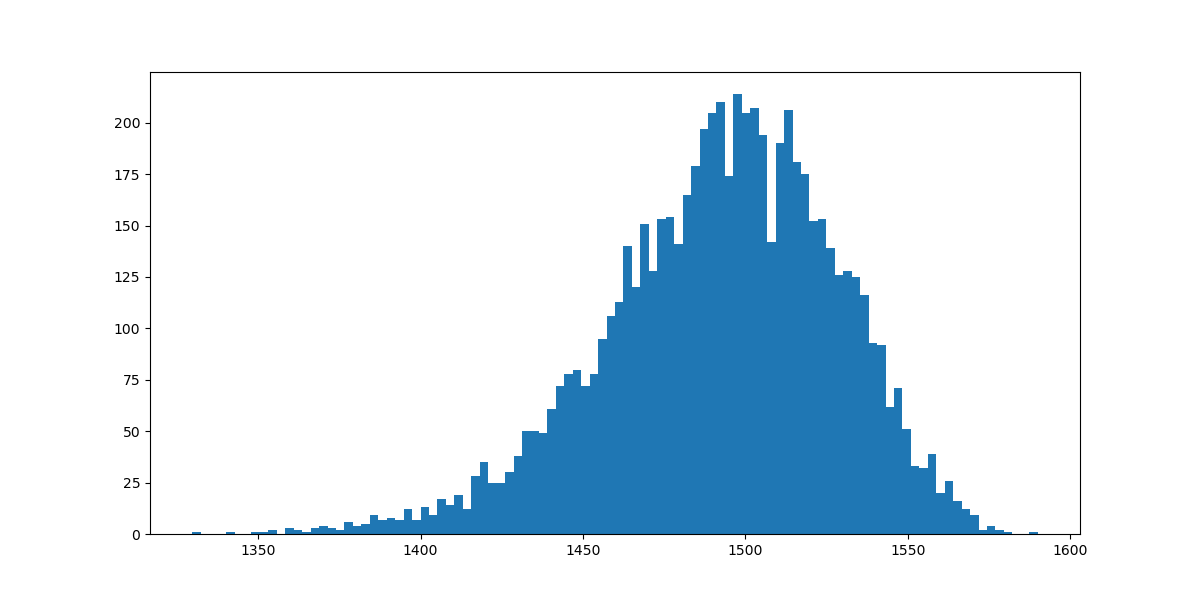

1492.2468387232357 35.68288414944936


In [127]:
plt.close()
plt.hist(signalminima,bins=(100))
plt.show()
print(np.mean(signalminima),np.std(signalminima))

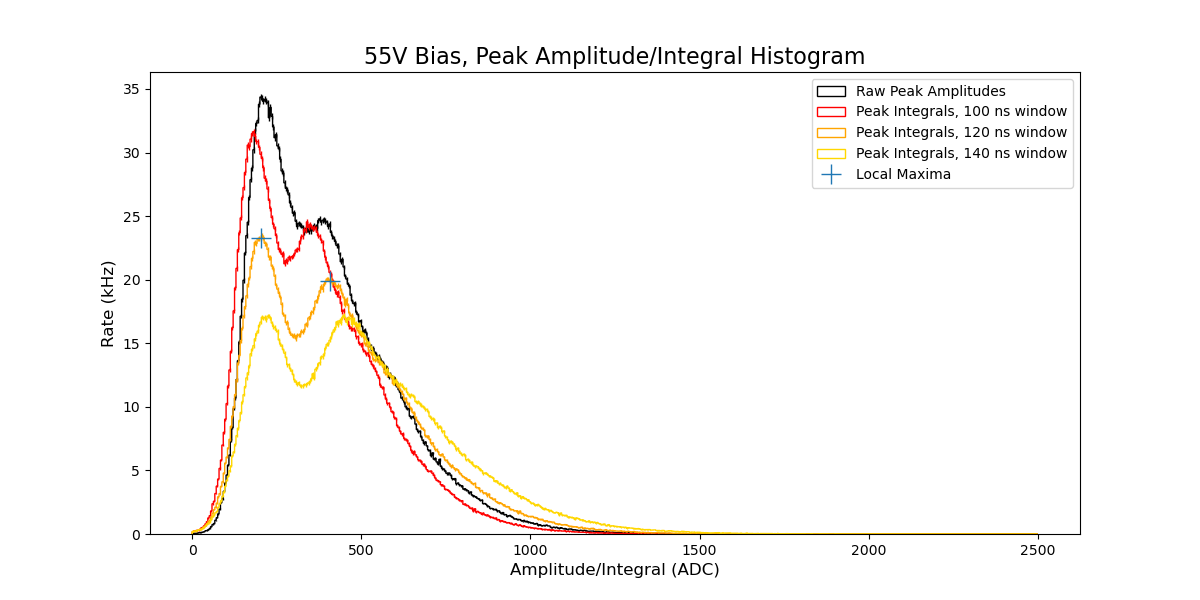

SPE Raw Amplitude: 202.08
Total PE Rate (raw peaks), sum(rate*PE amp): 6006.4 kHz

Integer PE Amplitude (short window): 181.2*5.0
SPE Charge: 906.25
Total PE Rate, sum(rate*PE amp): 5639.6 kHz

***
1 PE Amplitude (medium window): 202.1*5.0
SPE Charge: 1010.42
Total PE Rate, sum(rate*PE amp): 5574.5 kHz

2 PE Amplitude (medium window): 203.1*5.0
SPE Charge: 1015.62
Total PE Rate, sum(rate*PE amp): 5545.9 kHz

PE Amplitude spacing (medium window): 204.2*5.0
SPE Charge: 1020.83
Total PE Rate, sum(rate*PE amp): 5517.6 kHz
***
Integer PE Amplitude (long window): 224.0*5.0
SPE Charge: 1119.79
Total PE Rate, sum(rate*PE amp): 5399.6 kHz



In [74]:
# was -330, now -324
mybins = 600
myrange = (0,2500)
myreduction = 0.2 # divide integrals by ~5 so distribution can be visually compared to raw peak amplitude distribution

plt.close()
rawpks_s, bins, bars = plt.hist(np.concatenate(rawpeaks),weights=[integral_period/totsamples]*len(np.concatenate(rawpeaks)),bins=mybins,range=myrange,histtype="step",label="Raw Peak Amplitudes",color='black')
amplitude = bins[:-1]*0.5+bins[1:]*0.5
plt.errorbar(amplitude, rawpks_s, yerr=np.sqrt(rawpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='black')

intpks_s, bins, bars = plt.hist(np.concatenate(intpeaks_s)*myreduction,weights=[1000/(time[-mywindow[0]]-time[0])/totsamples]*len(np.concatenate(intpeaks_s)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[0]]-time[0])*1000:.0f} ns window",color='red')
plt.errorbar(amplitude, intpks_s, yerr=np.sqrt(intpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='red')

intpks_m, bins, bars = plt.hist(np.concatenate(intpeaks_m)*myreduction,weights=[1000/(time[-mywindow[1]]-time[0])/totsamples]*len(np.concatenate(intpeaks_m)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[1]]-time[0])*1000:.0f} ns window",color='orange')
plt.errorbar(amplitude, intpks_m, yerr=np.sqrt(intpks_m*10/totsamples),
            linewidth=0, elinewidth=1,color='orange')

intpks_l, bins, bars = plt.hist(np.concatenate(intpeaks_l)*myreduction,weights=[1000/(time[-mywindow[2]]-time[0])/totsamples]*len(np.concatenate(intpeaks_l)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[2]]-time[0])*1000:.0f} ns window",color='gold')
plt.errorbar(amplitude, intpks_l, yerr=np.sqrt(intpks_l*10/totsamples),
            linewidth=0, elinewidth=1,color='gold')

#peaks2,props2 = find_peaks(intpks_s,height=0,width=5,prominence=1,distance=5)
SPEcharge_s = amplitude[np.argmax(intpks_s)]
SPEcharge_m = amplitude[np.argmax(intpks_m)]
SPEcharge_l = amplitude[np.argmax(intpks_l)]/2
peaks2,props2 = find_peaks(intpks_m,height=0,width=5,prominence=0.2,distance=5)
peaks2[0] -= 1
peaks2[1] += 1

SPEcharge_peak1 = amplitude[peaks2[0]]
SPEcharge_peak2 = amplitude[peaks2[1]]/2
SPEcharge_peakdiff = amplitude[peaks2][1]-amplitude[peaks2][0]



plt.plot(amplitude[peaks2],intpks_m[peaks2],linestyle="",marker="+",markersize=15,label="Local Maxima")
#plt.yscale("log")
plt.legend()
plt.title("55V Bias, Peak Amplitude/Integral Histogram", size=16)
plt.xlabel("Amplitude/Integral (ADC)", size=12)
plt.ylabel("Rate (kHz)", size=12)
plt.show()

# actual period: time[-mywindow[0]]-time[0]

print(f"SPE Raw Amplitude: {amplitude[np.argmax(rawpks_s)]:.2f}")
print(f"Total PE Rate (raw peaks), sum(rate*PE amp): {sum(rawpks_s*amplitude)/amplitude[np.argmax(rawpks_s)]:.1f} kHz\n")

print(f"Integer PE Amplitude (short window): {SPEcharge_s:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_s/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_s*amplitude)/SPEcharge_s:.1f} kHz\n")

print(f"***\n1 PE Amplitude (medium window): {SPEcharge_peak1:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peak1/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude)/SPEcharge_peak1:.1f} kHz\n")

print(f"2 PE Amplitude (medium window): {SPEcharge_peak2:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peak2/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude)/SPEcharge_peak2:.1f} kHz\n")

print(f"PE Amplitude spacing (medium window): {SPEcharge_peakdiff:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peakdiff/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*(amplitude))/SPEcharge_peakdiff:.1f} kHz\n***")


# also want to treat the dark signal the same as the bright signal
    # dcoffset and divide total integral
    # original script only saved averages and stdevs, need to re-analyze

print(f"Integer PE Amplitude (long window): {SPEcharge_l:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_l/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_l*amplitude/SPEcharge_l):.1f} kHz\n")

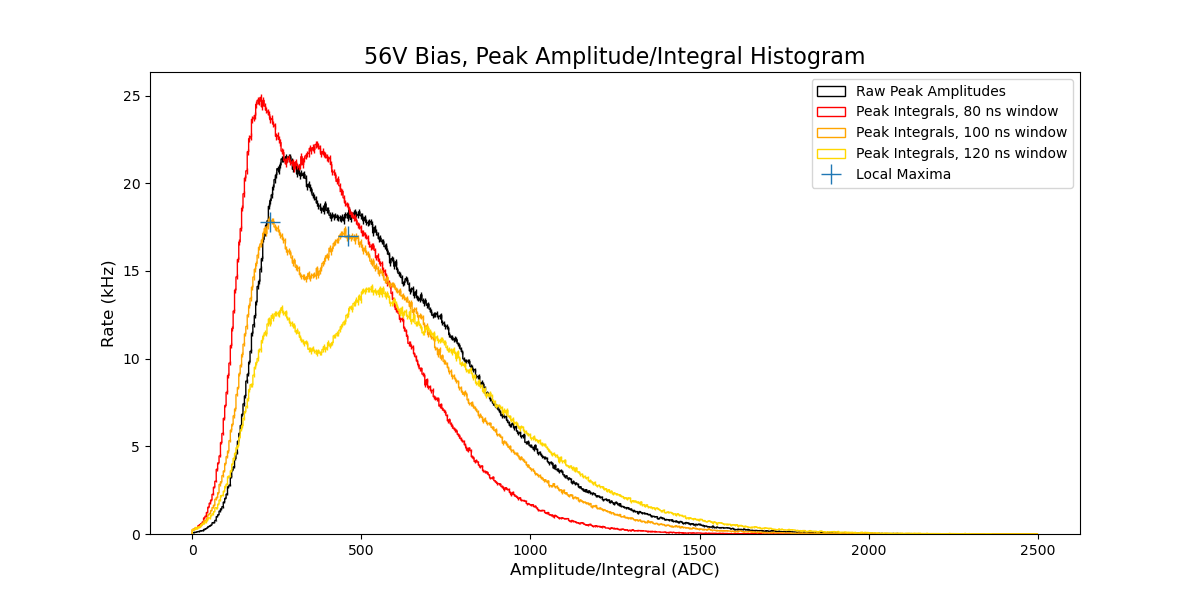

SPE Raw Amplitude: 289.58
Total PE Rate (raw peaks), sum(rate*PE amp): 6239.0 kHz

Integer PE Amplitude (short window): 202.1*5.0
SPE Charge: 1010.42
Total PE Rate, sum(rate*PE amp): 6371.3 kHz

***
1 PE Amplitude (medium window): 231.2*5.0
SPE Charge: 1156.25
Total PE Rate, sum(rate*PE amp): 6441.0 kHz

2 PE Amplitude (medium window): 230.2*5.0
SPE Charge: 1151.04
Total PE Rate, sum(rate*PE amp): 6470.2 kHz

PE Amplitude spacing (medium window): 229.2*5.0
SPE Charge: 1145.83
Total PE Rate, sum(rate*PE amp): 6499.6 kHz
***
Integer PE Amplitude (long window): 265.6*5.0
SPE Charge: 1328.12
Total PE Rate, sum(rate*PE amp): 6203.7 kHz



In [78]:
# was -320, now -330
mybins = 600
myrange = (0,2500)
myreduction = 0.2 # divide integrals by ~5 so distribution can be visually compared to raw peak amplitude distribution

plt.close()
rawpks_s, bins, bars = plt.hist(np.concatenate(rawpeaks),weights=[integral_period/totsamples]*len(np.concatenate(rawpeaks)),bins=mybins,range=myrange,histtype="step",label="Raw Peak Amplitudes",color='black')
amplitude = bins[:-1]*0.5+bins[1:]*0.5
plt.errorbar(amplitude, rawpks_s, yerr=np.sqrt(rawpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='black')

intpks_s, bins, bars = plt.hist(np.concatenate(intpeaks_s)*myreduction,weights=[1000/(time[-mywindow[0]]-time[0])/totsamples]*len(np.concatenate(intpeaks_s)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[0]]-time[0])*1000:.0f} ns window",color='red')
plt.errorbar(amplitude, intpks_s, yerr=np.sqrt(intpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='red')

intpks_m, bins, bars = plt.hist(np.concatenate(intpeaks_m)*myreduction,weights=[1000/(time[-mywindow[1]]-time[0])/totsamples]*len(np.concatenate(intpeaks_m)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[1]]-time[0])*1000:.0f} ns window",color='orange')
plt.errorbar(amplitude, intpks_m, yerr=np.sqrt(intpks_m*10/totsamples),
            linewidth=0, elinewidth=1,color='orange')

intpks_l, bins, bars = plt.hist(np.concatenate(intpeaks_l)*myreduction,weights=[1000/(time[-mywindow[2]]-time[0])/totsamples]*len(np.concatenate(intpeaks_l)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[2]]-time[0])*1000:.0f} ns window",color='gold')
plt.errorbar(amplitude, intpks_l, yerr=np.sqrt(intpks_l*10/totsamples),
            linewidth=0, elinewidth=1,color='gold')

#peaks2,props2 = find_peaks(intpks_s,height=0,width=5,prominence=1,distance=5)
SPEcharge_s = amplitude[np.argmax(intpks_s)]
SPEcharge_m = amplitude[np.argmax(intpks_m)]
SPEcharge_l = amplitude[np.argmax(intpks_l)]/2
peaks2,props2 = find_peaks(intpks_m,height=0,width=5,prominence=2,distance=5)
peaks2[0] += 1
peaks2[1] += 2

SPEcharge_peak1 = amplitude[peaks2[0]]
SPEcharge_peak2 = amplitude[peaks2[1]]/2
SPEcharge_peakdiff = amplitude[peaks2][1]-amplitude[peaks2][0]



plt.plot(amplitude[peaks2],intpks_m[peaks2],linestyle="",marker="+",markersize=15,label="Local Maxima")
#plt.yscale("log")
plt.legend()
plt.title("56V Bias, Peak Amplitude/Integral Histogram", size=16)
plt.xlabel("Amplitude/Integral (ADC)", size=12)
plt.ylabel("Rate (kHz)", size=12)
plt.show()

# actual period: time[-mywindow[0]]-time[0]

print(f"SPE Raw Amplitude: {amplitude[np.argmax(rawpks_s)]:.2f}")
print(f"Total PE Rate (raw peaks), sum(rate*PE amp): {sum(rawpks_s*amplitude)/amplitude[np.argmax(rawpks_s)]:.1f} kHz\n")

print(f"Integer PE Amplitude (short window): {SPEcharge_s:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_s/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_s*amplitude)/SPEcharge_s:.1f} kHz\n")

print(f"***\n1 PE Amplitude (medium window): {SPEcharge_peak1:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peak1/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude)/SPEcharge_peak1:.1f} kHz\n")

print(f"2 PE Amplitude (medium window): {SPEcharge_peak2:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peak2/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude)/SPEcharge_peak2:.1f} kHz\n")

print(f"PE Amplitude spacing (medium window): {SPEcharge_peakdiff:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_peakdiff/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*(amplitude))/SPEcharge_peakdiff:.1f} kHz\n***")


# also want to treat the dark signal the same as the bright signal
    # dcoffset and divide total integral
    # original script only saved averages and stdevs, need to re-analyze

print(f"Integer PE Amplitude (long window): {SPEcharge_l:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_l/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_l*amplitude/SPEcharge_l):.1f} kHz\n")

In [79]:
print(f"Mean Integral: {np.mean(rawintegrals):.1f}")
print(f"Charges (1, 2, diff):\n{SPEcharge_peak1/myreduction:.1f}\n\
{SPEcharge_peak2/myreduction:.1f}\n\
{SPEcharge_peakdiff/myreduction:.1f}")
print(f"Equivalent pe rate (1, 2, diff):\n\
{np.mean(rawintegrals/(SPEcharge_peak1/myreduction)*integral_period):.1f}\n\
{np.mean(rawintegrals/(SPEcharge_peak2/myreduction)*integral_period):.1f}\n\
{np.mean(rawintegrals/(SPEcharge_peakdiff/myreduction)*integral_period):.1f}")
# still way too high -- clearly the integral window is not the whole integral
window_fraction1 = sum(intpks_m*(amplitude))/SPEcharge_peak1/np.mean(rawintegrals/(SPEcharge_peak1/myreduction)*integral_period)
window_fraction2 = sum(intpks_m*(amplitude))/SPEcharge_peak2/np.mean(rawintegrals/(SPEcharge_peak2/myreduction)*integral_period)
window_fractiondiff = sum(intpks_m*(amplitude))/SPEcharge_peakdiff/np.mean(rawintegrals/(SPEcharge_peakdiff/myreduction)*integral_period)

corrected_spe_charge1 = SPEcharge_peak1/myreduction/window_fraction1
corrected_spe_charge2 = SPEcharge_peak2/myreduction/window_fraction2
corrected_spe_chargediff = SPEcharge_peakdiff/myreduction/window_fractiondiff

corrected_pe_rate1 = sum(intpks_m*amplitude)/SPEcharge_peak1
corrected_pe_rate2 = sum(intpks_m*amplitude)/SPEcharge_peak2
corrected_pe_ratediff = sum(intpks_m*amplitude)/SPEcharge_peakdiff

print(f"Corrected rates (1, 2, diff):\n\
{corrected_pe_rate1:.1f}, {corrected_pe_rate2:.1f}, {corrected_pe_ratediff:.1f}")

print(f"Correction and Corrected pe charges (1, 2, diff):\n\
{window_fraction1:.4f}, {corrected_spe_charge1:.1f}\n\
{window_fraction2:.4f}, {corrected_spe_charge2:.1f}\n\
{window_fractiondiff:.4f}, {corrected_spe_chargediff:.1f}")

calibrated_rate = np.mean([corrected_pe_rate1,corrected_pe_rate2,corrected_pe_ratediff])
rate_uncertainty = np.std([corrected_pe_rate1,corrected_pe_rate2,corrected_pe_ratediff])
calibrated_charge = np.mean([corrected_spe_charge1,corrected_spe_charge2,corrected_spe_chargediff])

Mean Integral: 1619352.0
Charges (1, 2, diff):
1156.2
1151.0
1145.8
Equivalent pe rate (1, 2, diff):
14013.6
14077.0
14141.0
Corrected rates (1, 2, diff):
6441.0, 6470.2, 6499.6
Correction and Corrected pe charges (1, 2, diff):
0.4596, 2515.6
0.4596, 2504.3
0.4596, 2493.0


[1619351.79736328 1619351.92163086 1619352.30651855 1619351.90673828
 1619352.1986084 ] [323.99995946 323.99998432 324.00006133 323.99998134 324.00003974]


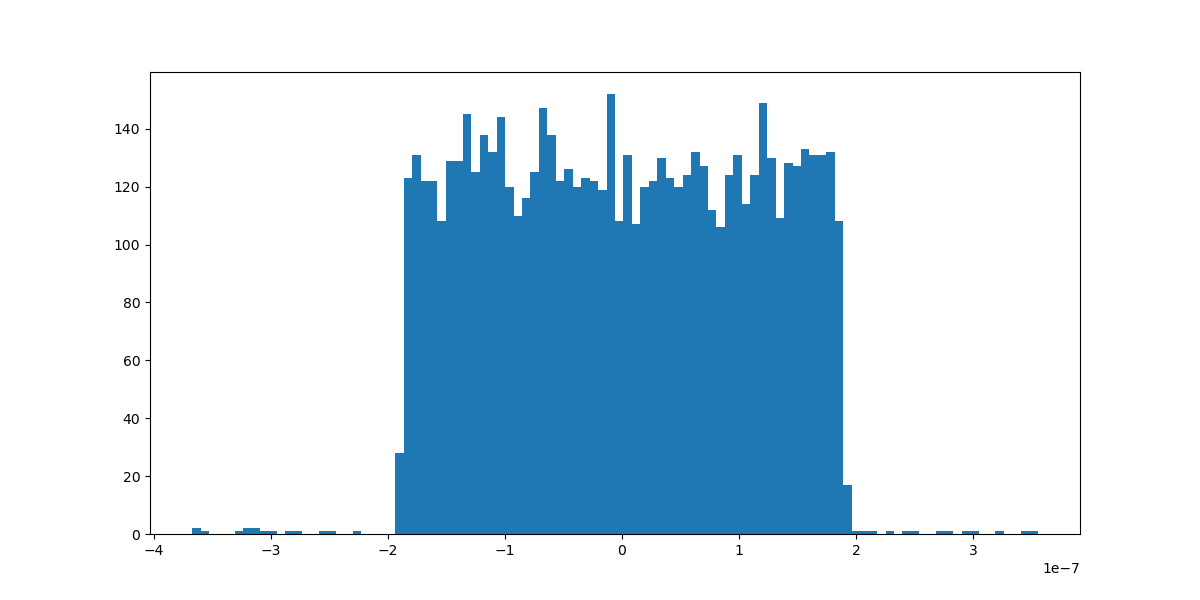

323.99999998323966 3.58850163346377e-05


In [109]:
print(rawintegrals[-6:-1],rawmeans[-6:-1])
plt.close()
plt.hist((rawmeans-323.99999998323966)/323.99999998323966,bins=100)
#plt.hist(rawintegrals/SPEcharge_peakdiff)
plt.show()
bins = bins[:-1]*0.5+bins[1:]*0.5
print(np.mean(rawmeans),np.std(rawmeans))

# compare consistency of mean value to consistency of integral after DC subtraction
# mean subtraction only

In [170]:
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*(amplitude-amplitude_offset))/SPEcharge_peakdiff:.1f} kHz\n")
DCoff,amplitude_offset/myreduction
# already raise it by 217 ADC
# In the above sum, what is the equivalent DCoffset?
    # windowed integral (window size mywindow[1]) amplitude reduced by amplitude_offset, thus every sample was reduced by amplitude_offset/mywindow[1]
print(DCoff,amplitude_offset/myreduction,(amplitude_offset/myreduction)/mywindow[1],np.mean((rawintegrals- 4998*(amplitude_offset/myreduction)/mywindow[1])/(SPEcharge_peakdiff/myreduction)*integral_period))

# total ADCs removed from integral:
    # len(signal)*(amplitude_offset/myreduction)/mywindow[1])
    # when I have a new signal that hasn't been down-sampled, there will be 5x more samples to sum, but the !!!!same total ADC!!!
    # I only care to remove the total excess ADCs from the integral -- why calculate the ADC per sample to multiply by the sample count when I already know the number of samples
    # number of samples and amplitude offset will be the same for every one
print(f"Unsubtracted pe rate (diff):\n\
{np.mean(rawintegrals/(SPEcharge_peakdiff/myreduction)*integral_period):.1f}")

#print(f"Subtracted pe rate (diff):\n\
#np.mean((rawintegrals- 4998*(amplitude_offset/myreduction)/mywindow[1])/(SPEcharge_peakdiff/myreduction)*integral_period)

Total PE Rate, sum(rate*PE amp): 5544.4 kHz

-217 -10.416666666666572 -1.7361111111110954 10715.749449449073
Unsubtracted pe rate (diff):
10630.7


In [ ]:
# uncertainty in SPE charge (this is uncertainty in dark rate too)
# uncertainty in integral (very small)
# integral is downsampled, smoothed, DC-offset from digitizer (uncertainties cancel?)

# rawcount = (integral +- sigma_int) / (SPE +- sigma_SPE) +- sqrt(integral / SPE)
# rawcount = (integral) / (SPE) +- (integral/SPE*sigma_SPE/SPE) +- sqrt(integral / SPE)
# add in quadrature
# rawcount = (integral) / (SPE) +- sqrt(integral / SPE + (integral/SPE*sigma_SPE/SPE)^2 )

# darkcount = darkintegral  / (SPE +- sigma_SPE) +- sqrt(integral / SPE)
# count = (rawcount +-sigma_raw) - darkcount

In [66]:
calibrated_rate = np.mean([corrected_pe_rate1,corrected_pe_rate2,corrected_pe_ratediff])
rate_uncertainty = np.std([corrected_pe_rate1,corrected_pe_rate2,corrected_pe_ratediff])
calibrated_charge = np.mean([corrected_spe_charge1,corrected_spe_charge2,corrected_spe_chargediff])

In [63]:
calibrated_charge

1956.7865168131

In [80]:
#### Initialize data structure to save results

try: 
    mycalibrations
except NameError:
    mycalibrations = np.array([[int(inputfile.file_path[-9:-5]),
                                calibrated_rate, rate_uncertainty, calibrated_charge]])
else:
    if (int(inputfile.file_path[-9:-5]) not in (mycalibrations)): 
        mycalibrations = np.append(mycalibrations,np.array([[int(inputfile.file_path[-9:-5]),
                                                             calibrated_rate, rate_uncertainty, calibrated_charge]]),axis=0)
    else: print("Calbiration output already defined with entry for that file!\n",mycalibrations)

In [81]:
#mycalibrations[0][0] = 0
mycalibrations

array([[1919.        , 5546.01202572,   23.22229921, 1956.78651681],
       [1921.        , 6470.25233617,   23.90488705, 2504.30157525]])